TODO
1. extract features by googlenet
2. compute similarity
3. test on Place dataset

## Feature extraction

In [236]:
database = "images/Nordland_data"
query = "images/Nordland_query"

### Using GoogLenet

In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from googlenet_places205 import GoogLeNetPlaces205
model = GoogLeNetPlaces205()
model.load_state_dict(torch.load("googlenet_places205.pth"))

# from googlenet_places365 import GoogLeNetPlaces365
# model = GoogLeNetPlaces365()
# model.load_state_dict(torch.load("googlenet_places365.pth"))

features = {}


def get_middle_output(name):
    def hook(model, input, output):
        features[name] = (output.detach())
    return hook


model.inception_3a_3x3_reduce.register_forward_hook(get_middle_output('icp1'))


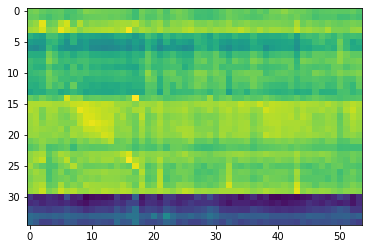

In [238]:
import os
from PIL import Image
from torchvision import transforms


def preprocess_singe_img(filename):
    input_image = Image.open(filename)
    transform = transforms.Compose([
        transforms.Resize([224,224]),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
    ])
    input_tensor = transform(input_image)
    # create a mini-batch as expected by the model
    input_batch = input_tensor.unsqueeze(0)
    return input_batch, np.array(input_image)


def get_features(input):
    output = model(input)
    return features['icp1'].flatten()


def get_similarity(input1, input2):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    return cos(input1, input2)


def process_images_from_folder(folder):
    image_features = []
    images = []
    dir_list = sorted(os.listdir(folder))
    for filename in dir_list:
        if filename is not None:
            input, image = preprocess_singe_img(folder + '/' + filename)
            images.append(image)
            image_features.append(get_features(input))
    # print(image_features[0].shape)
    return image_features, images


database_features, database_images = process_images_from_folder(database)
query_features, query_images = process_images_from_folder(query)

similarity_matrix = np.zeros(
    (len(query_features), len(database_features)))  # Q by D

for i in range(len(query_features)):
    for j in range(len(database_features)):
        similarity_matrix[i][j] = get_similarity(
            query_features[i], database_features[j])
normalized_mat=F.normalize(torch.tensor(similarity_matrix),dim=0)
similarity_matrix=np.array(normalized_mat)
plt.imshow(similarity_matrix)
plt.show()


### Using HOG

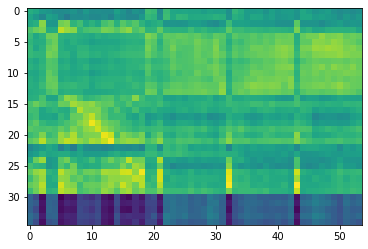

In [239]:
from skimage.feature import hog
from skimage import exposure


def hog_preprocess_singe_img(filename):
    input_image = Image.open(filename)
    transform = transforms.Compose([
        transforms.Resize([1024,768]),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=1),
    ])
    input_tensor = transform(input_image)
    # input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_tensor, np.array(input_image)


def get_hog_features(input):
    fd = hog(input.squeeze(), orientations=10, pixels_per_cell=(32, 32),
             cells_per_block=(2, 2))
    return fd


def hog_process_images_from_folder(folder):
    image_features = []
    images = []
    dir_list = sorted(os.listdir(folder))
    for filename in dir_list:
        if (filename is not None):
            input, image = hog_preprocess_singe_img(folder + '/' + filename)
            image_features.append(get_hog_features(input))
            images.append(image)
    return image_features, images


hog_database_features, hog_database_images = hog_process_images_from_folder(
    database)
hog_query_features, hog_query_images = hog_process_images_from_folder(query)

hog_similarity_matrix = np.zeros(
    (len(hog_query_features), len(hog_database_features)))  # Q by D

for i in range(len(hog_query_features)):
    for j in range(len(hog_database_features)):
        hog_similarity_matrix[i][j] = get_similarity(torch.from_numpy(
            hog_query_features[i]), torch.from_numpy(hog_database_features[j]))
normalized_mat=F.normalize(torch.tensor(hog_similarity_matrix),dim=0)
hog_similarity_matrix=np.array(normalized_mat)
plt.imshow(hog_similarity_matrix)
plt.show()


Show pictures

In [240]:
def visualize(database_images, query_images, similarity_matrix, query_num=10):
    matches = np.argmax(similarity_matrix, axis=1)
    # query_num=len(query_images)
    fig, ax = plt.subplots(query_num, 2, figsize=(8, 60))
    fig.tight_layout()
    for i in range(query_num):
        ax[i, 0].imshow(query_images[i])
        ax[i, 0].set_title(i)
        ax[i, 1].imshow(database_images[matches[i]])
        ax[i, 1].set_title(matches[i])
    fig.show()

# visualize(hog_database_images,hog_query_images,hog_similarity_matrix)
# visualize(database_images,query_images,similarity_matrix)


## Minumum flow

In [241]:
import networkx as nx

In [242]:
# # An example of min cost flow
# G = nx.DiGraph()
# G.add_node("a", demand=-5)
# G.add_node("d", demand=5)
# G.add_edge("a", "b", weight=3, capacity=4)
# G.add_edge("a", "c", weight=6, capacity=10)
# G.add_edge("b", "d", weight=1, capacity=9)
# G.add_edge("c", "d", weight=2, capacity=5)
# flowDict = nx.min_cost_flow(G)
# print(flowDict)


In [320]:
# Generate the graph
def minCostFlow(similarity_matrix):
    # Definie our problem
    G = nx.DiGraph()

    # Size of query and data
    Q = similarity_matrix.shape[0]
    D = similarity_matrix.shape[1]

    F = 5  # Flow
    K = 4  # Span

    w_h = np.min(1/similarity_matrix)*1.008  # weight for connecting hidden units, 1.0-1.01

    G.add_node("s", demand=-F)
    G.add_node("t", demand=F)

    # Episolon s
    for j in range(1, D+1):
        G.add_edge("s", (1, j), weight=0, capacity=1)
        G.add_edge("s", (-1, -j), weight=0, capacity=1)

    # Episolon t
    for j in range(1, D+1):
        G.add_edge((Q, j), "t", weight=0, capacity=1)
        G.add_edge((-Q, -j), "t", weight=0, capacity=1)

    # Episolon a and b
    for i in range(1, Q):
        for j in range(1, D+1):
            for k in range(j, min(max(j+K, D), D+1)):
                # print(k)
                G.add_edge((i, j), (i+1, k), weight=1 /
                           similarity_matrix[i-1][j-1], capacity=1)
                G.add_edge((-i, -j), (-i-1, -k), weight=w_h, capacity=1)
                G.add_edge((i, j), (-i-1, -k), weight=w_h, capacity=1)
                G.add_edge((-i, -j), (i+1, k), weight=1 /
                           similarity_matrix[i-1][j-1], capacity=1)
                # G.add_edge((i,j), (i+1,k), weight=0, capacity=1)
                # G.add_edge((-i,-j), (-i-1,-k), weight=0, capacity=1)
                # G.add_edge((i,j), (-i-1,-k), weight=0, capacity=1)
                # G.add_edge((-i,-j), (i+1,k), weight=0, capacity=1)

    # Episolon h
    for i in range(1, Q+1):
        for j in range(1, D-1):
            G.add_edge((i, j), (i, j+1), weight=0, capacity=1)
            G.add_edge((i, j), (-i, -j-1), weight=0, capacity=1)
            G.add_edge((-i, -j), (i, j+1), weight=0, capacity=1)
            G.add_edge((-i, -j), (-i, -j-1), weight=0, capacity=1)
    return G


In [321]:
G = minCostFlow(similarity_matrix)
print(G.number_of_edges())

202656


In [322]:
print(np.min(1/similarity_matrix))

5.84119638071563


In [323]:
# min cost flow solution
# flowDict = nx.min_cost_flow(G)
# print(flowDict)

In [324]:
# if nx.is_directed_acyclic_graph(G):
#     print(list(reversed(list(nx.topological_sort(G)))))

In [325]:
def visualizeList(database_images, query_images, shortest_list):
    query_num = len(shortest_list)-2
    # query_num=len(query_images)
    fig, ax = plt.subplots(query_num, 2, figsize=(8, 60))
    fig.tight_layout()
    for i in range(query_num):
        ax[i, 0].imshow(query_images[i])
        ax[i, 0].set_title(i)
        index = shortest_list[i+1][1]-1
        if index>0:
            ax[i, 1].imshow(database_images[index])
            ax[i, 1].set_title(index)
        else:
            ax[i, 1].imshow(query_images[i])
            ax[i, 1].set_title("not found")
    fig.show()


In [326]:
# nx.draw_networkx(G)
# nx.write_gexf(G, "test.gexf")


In [327]:
# for u in flowDict:
#     for v in flowDict[u]:
#         if flowDict[u][v]>0:
#             print(u,v)

# list_flow = [(u, v)
#              for u in flowDict for v in flowDict[u] if flowDict[u][v] > 0]


['s', (1, 1), (-2, -1), (-3, -3), (4, 6), (5, 6), (-6, -6), (-7, -6), (-8, -6), (-9, -6), (-10, -6), (-11, -6), (-12, -6), (-13, -6), (-14, -6), (-15, -7), (16, 9), (17, 9), (18, 10), (19, 11), (20, 12), (21, 13), (22, 14), (23, 14), (-24, -17), (25, 17), (26, 18), (27, 19), (28, 22), (29, 33), (30, 44), (31, 44), (-32, -44), (-33, -44), (-34, -44), (-35, -44), 't']


C:\Users\ranba\AppData\Local\Temp\ipykernel_27108\653646967.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


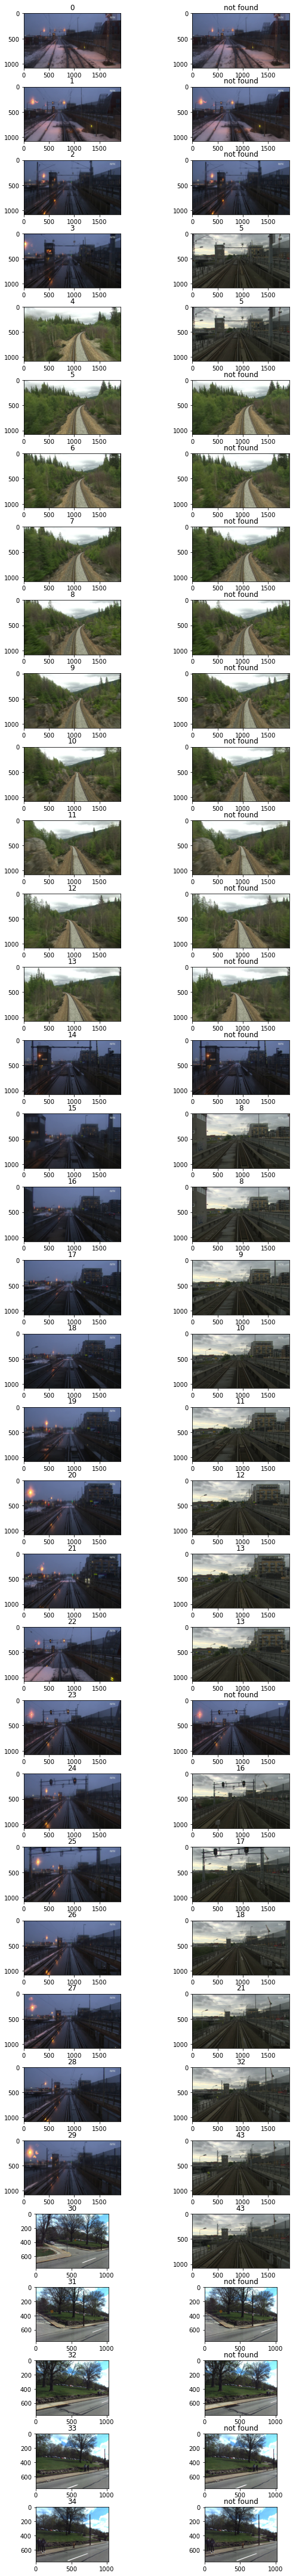

In [328]:
shortest_list = nx.shortest_path(G, "s", "t", weight="weight")
print(shortest_list)

visualizeList(database_images, query_images, shortest_list)


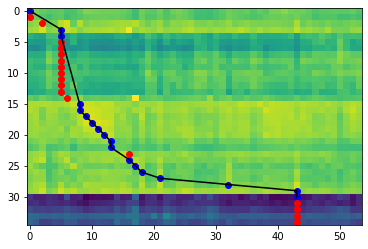

In [329]:

def visualization(shortest_list, similarity_matrix):
    match_query = []
    match_data = []
    unmatch_query = []
    unmatch_data = []
    for i in range(1, len(shortest_list)-1):
        index_1 = shortest_list[i][0]
        index_2 = shortest_list[i][1]
        if index_1>=0:
            match_query.append(index_1-1)
            match_data.append(index_2-1)
        else:
            unmatch_query.append(-index_1-1)
            unmatch_data.append(-index_2-1)
    plt.imshow(similarity_matrix)
    plt.scatter(match_data, match_query, color='b')
    plt.scatter(unmatch_data, unmatch_query, color='r')
    plt.plot(match_data, match_query, color='black')
    plt.show()


visualization(shortest_list, similarity_matrix)


In [330]:
# class evaluator():
#     def __init__(self,shortest_list,tolerance=3):
#         self.shortest_list=shortest_list
#         self.tolerance=tolerance
#         self.calculate()
#     def calculate(self):
#         TP=0
#         FP=0
#         TN=0
#         FN=0
#         query = []
#         data = []
#         for i in range(1, len(shortest_list)-1):
#             query.append(shortest_list[i][0]-1)
#             data.append(shortest_list[i][1]-1)
#         for i in range(len(query)):
#             if not (abs(query[i]-data[i])>self.tolerance):
#                 TP+=1
#             else:
#                 if query[i] in data:
#                     FP+=1
                